In [1]:
loading = True

In [2]:
from utils.utils import (
    lat_lon_to_epsg)
import warnings
warnings.filterwarnings('ignore')
from datacube import Datacube
import xarray
import ipywidgets as widgets
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
from datacube.storage import masking  # Import masking capabilities
import pandas as pd
import warnings
import uuid

warnings.filterwarnings('ignore')

dc = Datacube()

###need to add lat long and address search

if 'center' not in locals():
    center =[-34.42989,116.63979]
    
zoom = 13

product_summary = widgets.Output(layout={'border': '1px solid black'})
#dimensions = widgets.Output(layout={'border': '1px solid black'})



def generate_available_datasets_table():
    products_from_cube = dc.list_products()
    product_list = list(dc.list_products()['name'].values)
    product_description = list(dc.list_products()['description'].values)
    
    build_table = []
    
    config = load_config('./configIndex.txt')
    
    for num, product in enumerate(product_list):
        ds = dc.find_datasets(product=product,
                 latitude=tuple(config['lat']),
                 longitude=tuple(config['lon']),
                 time=tuple(sorted(config['time']))
                 )
        captured_dates = []
        for dataset in ds:
            captured_dates.append(dataset.time.begin.date())
        if len(captured_dates)>0:
            number_epochs = len(set(captured_dates))
            number_tiles =  len(captured_dates)

            captured_dates_sorted = sorted(captured_dates)

            start_date = captured_dates_sorted[0]
            end_date = captured_dates_sorted[len(captured_dates_sorted)-1]


            build_table.append([product,
                               product_description[num],
                               number_tiles,
                               number_epochs,
                               start_date,
                               end_date
                               ])
    build_table = pd.DataFrame(build_table,columns = ['Product Name', 
                                                    'Product Description',
                                                    'Number of Tiles',
                                                    'Number of Epochs',
                                                    'Start Date',
                                                    'End Date'])
    product_summary.clear_output()
    with product_summary:
        display(build_table)


def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data
    
def update_config(filename,variable,value):
    
    with open(filename, 'r') as f:
        data = json.load(f)
        data[variable] = value
        
    os.remove(filename)
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

m = Map(center=center, zoom=zoom)
m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
draw_control2 = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})

def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
        
        lon_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])
        lon_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])

        lat_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        lat_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        EPSG = lat_lon_to_epsg(lat_max,lon_min)
        
        
        
        #lat = {'lat' : (lat_max,lat_min),
        #          'lon' : (lon_max,lon_min)}
        update_config('./configIndex.txt',
                 'output_crs',
                 'epsg:' + EPSG)
            
        update_config('./configIndex.txt',
                 'lat',
                 (lat_max,lat_min))

        update_config('./configIndex.txt',
                 'lon',
                 (lon_max,lon_min))
        update_config('./configIndex.txt',
              'geoJSON',
              draw_control.last_draw
             )
        update_config('./configIndex.txt',
              'load_id',
              str(uuid.uuid4())
             )


    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
        
        lon_max = max([draw_control2.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][0]])
        lon_min = min([draw_control2.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][0]])

        lat_max = max([draw_control2.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][1]])
        lat_min = min([draw_control2.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][1]])
        EPSG = lat_lon_to_epsg(lat_max,lon_min)
        
        update_config('./configIndex.txt',
                 'output_crs',
                 'epsg:' + EPSG)
            
        update_config('./configIndex.txt',
                 'lat',
                 (lat_max,lat_min))

        update_config('./configIndex.txt',
                 'lon',
                 (lon_max,lon_min))
        
        update_config('./configIndex.txt',
                      'geoJSON',
                      draw_control2.last_draw
                     )
        update_config('./configIndex.txt',
              'load_id',
              str(uuid.uuid4())
             )


    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

dates = [datetime.date(1986,1,1) + datetime.timedelta(days =i) for i in range(1,12550)]
date_range = SelectionRangeSlider(options=dates,
                                          description = 'Date Range',
                                          disabled=False,
                                          layout = Layout(width='100%',height = '100px'))

def date_func(b):
    start_date,end_date = date_range.value
    update_config('./configIndex.txt',
                  'time',
                  (start_date.strftime("%Y-%m-%d"),
                   end_date.strftime("%Y-%m-%d")))

    generate_available_datasets_table()

button = widgets.Button(description="Query Cube",
                       button_Style = 'success',
                       layout=Layout(width='100%', height = '40px'))

button.on_click(date_func)
    
case_study_select = VBox([m,m2,product_summary, date_range, button])
    
#date_range.observe(date_func, names = 'value')

exe_load = True

accordion = Accordion(children=[case_study_select])
accordion.set_title(0, 'Select Case Study')
accordion

Accordion(children=(VBox(children=(Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', '…

In [3]:
%macro select_case_study_area 2

Macro `select_case_study_area` created. To execute, type its name (without quotes).
=== Macro contents: ===
from utils.utils import (
    lat_lon_to_epsg)
import warnings
warnings.filterwarnings('ignore')
from datacube import Datacube
import xarray
import ipywidgets as widgets
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
from datacube.storage import masking  # Import masking capabilities
import pandas as pd
import warnings
import uuid

warnings.filterwarnings('ignore')

dc = Datacube()

###need to add lat long and address search

if 'center' not in locals():
    center =[-34.42989,116.63979]
    
zoom = 13

product_summary = widgets.Output(layout={'border': '1px solid black'})
#dimensions = widg

In [4]:
%store select_case_study_area

Stored 'select_case_study_area' (Macro)


In [5]:
#Sentinal App
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
import warnings
warnings.filterwarnings('ignore')

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None


if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'
    
###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_sentinal(measurements = None, cloud_mask = False):

    data = load_config(case_study)
    ds_s2a = dc.load(product='s2a_nrt_granule', 
                 measurements = ('nbar_red','nbar_green','nbar_blue','nbar_nir_1','nbar_swir_2','nbar_swir_3','fmask'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 resolution = (-10,10),
                 output_crs='epsg:3577')
    
    
    crs = ds_s2a.crs
    affine = ds_s2a.affine
    
    
    clear_pixels = [0,2,3]
    clear_pixels_mask = xarray.DataArray(np.in1d(ds_s2a.fmask, clear_pixels).reshape(ds_s2a.fmask.shape), 
                                         dims=ds_s2a.fmask.dims, 
                                         coords=ds_s2a.fmask.coords)
                     
    ds_s2a = ds_s2a.where(clear_pixels_mask)
        
    ds_s2a.attrs['crs'] = crs
    ds_s2a.attrs['affine'] = affine

    ds_s2b = dc.load(product='s2b_nrt_granule', 
                 measurements = ('nbar_red','nbar_green','nbar_blue','nbar_nir_1','nbar_swir_2','nbar_swir_3','fmask'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 resolution = (-10,10),
                 output_crs='epsg:3577')
    
    
    crs = ds_s2b.crs
    affine = ds_s2b.affine
    clear_pixels = [0,2,3]
    clear_pixels_mask = xarray.DataArray(np.in1d(ds_s2b.fmask, clear_pixels).reshape(ds_s2b.fmask.shape), 
                                         dims=ds_s2b.fmask.dims, 
                                         coords=ds_s2b.fmask.coords)
    
    ds_s2b = ds_s2b.where(clear_pixels_mask)
    ds_s2b.attrs['crs'] = crs
    ds_s2b.attrs['affine'] = affine
    
    ds = xarray.merge([ds_s2a,ds_s2b])
    ds.attrs['crs'] = crs
    ds.attrs['affine'] = affine
    
    
    return ds

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()


if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset_sent,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    
    if 'loaded' in locals():
        if loaded['sent'] != config['load_id'] or loaded['sent'] is None:
            print ('Retrieving New Cube')
            ds = load_into_cube_sentinal()
            target_dataset_sent,desc = BandIndices.calculate_indices(ds,'NDVI')
            loaded['sent'] = config['load_id']

    
    m3.add_layer(GeoJSON(data=geoJSON_Extent))



indicesa = ['NDVI','GNDVI','NDWI', 'NDMI', 'NDBI', 'NBR']

with info:
         print(desc)

indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset_sent
    target_dataset_sent, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

    info.clear_output()
    with info:
         print(desc)

indices_buttons.observe(indices_func, names = 'value')

labels = []

dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577

def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(-1, 1)
    
    #print (geo_json)
    
    if geo_json['geometry']['type'] == 'Point':

        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
        
        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = target_dataset_sent.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        
        
        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)
        
        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)
        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        
        dataMasked = target_dataset_sent.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        try:
            data_masked_mean = data_masked_mean.interpolate_na(dim = 'time', method = 'nearest')
        except:
            print ('Unable to interpolate unknown values.')
        
        xarray.plot.plot(data_masked_mean, marker='*')

        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)
        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1
    
    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [6]:
%macro sentinel_band_indices_app 5

Macro `sentinel_band_indices_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
#Sentinal App
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
import warnings
warnings.filterwarnings('ignore')

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
   

In [7]:
%store sentinel_band_indices_app

Stored 'sentinel_band_indices_app' (Macro)


In [8]:
##Landsat 8 Geomedians  
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None
    
    
if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_geomedian(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    ds = dc.load(product='ls8_nbart_geomedian_annual', 
                 measurements = ('red','green','blue','nir','swir1','swir2'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 resolution = (-25,25))

    
    return ds

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset_landsat8_geomed,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded['landsat8_geomed'] != config['load_id'] or loaded['landsat8_geomed'] is None:
            print ('Retrieving New Cube')
            ds = load_into_cube_geomedian()
            target_dataset_landsat8_geomed,desc = BandIndices.calculate_indices(ds,'NDVI')
            loaded['landsat8_geomed'] = config['load_id']
    

    m3.add_layer(GeoJSON(data=geoJSON_Extent))



indicesa = ['NDVI','GNDVI','NDWI', 'NDMI', 'NDBI', 'NBR']

with info:
         print(desc)

indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset_landsat8_geomed
    target_dataset_landsat8_geomed, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

    info.clear_output()
    with info:
         print(desc)

indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(-1, 1)

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = target_dataset_landsat8_geomed.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        dataMasked = target_dataset_landsat8_geomed.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        #data_masked_mean.plot()

        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        xarray.plot.plot(data_masked_mean, marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        
        

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [9]:
%macro geomedian_landsat8_band_indices_app 8

Macro `geomedian_landsat8_band_indices_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 8 Geomedians  
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8

In [10]:
%store geomedian_landsat8_band_indices_app

Stored 'geomedian_landsat8_band_indices_app' (Macro)


In [11]:
##Landsat 7 Geomedians  
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_geomedian(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    ds = dc.load(product='ls7_nbart_geomedian_annual', 
                 measurements = ('red','green','blue','nir','swir1','swir2'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 resolution = (-25,25))

    
    return ds

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset_landsat7_geomed,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded['landsat7_geomed'] != config['load_id'] or loaded['landsat7_geomed'] is None:
            print ('Retrieving New Cube')
            ds = load_into_cube_geomedian()
            target_dataset_landsat7_geomed,desc = BandIndices.calculate_indices(ds,'NDVI')
            loaded['landsat7_geomed'] = config['load_id']

    m3.add_layer(GeoJSON(data=geoJSON_Extent))



indicesa = ['NDVI','GNDVI','NDWI', 'NDMI', 'NDBI', 'NBR']

with info:
         print(desc)

indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset_landsat7_geomed
    target_dataset_landsat7_geomed, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

    info.clear_output()
    with info:
         print(desc)

indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(-1, 1)

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = target_dataset_landsat7_geomed.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        dataMasked = target_dataset_landsat7_geomed.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        #data_masked_mean.plot()

        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        xarray.plot.plot(data_masked_mean, marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [12]:
%macro geomedian_landsat7_band_indices_app 11

Macro `geomedian_landsat7_band_indices_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 7 Geomedians  
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_fra

In [13]:
%store geomedian_landsat7_band_indices_app

Stored 'geomedian_landsat7_band_indices_app' (Macro)


In [14]:
##Landsat 5 Geomedians  
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_geomedian(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    ds = dc.load(product='ls5_nbart_geomedian_annual',
                 measurements = ('red','green','blue','nir','swir1','swir2'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 resolution = (-25,25))

    
    return ds

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded['landsat5_geomed'] != config['load_id'] or loaded['landsat5_geomed'] is None:
            print ('Retrieving New Cube')
            ds = load_into_cube_geomedian()
            target_dataset_landsat5_geomed,desc = BandIndices.calculate_indices(ds,'NDVI')
            loaded['landsat5_geomed'] = config['load_id']
    
    #ds = load_into_cube_geomedian()
    #target_dataset,desc = BandIndices.calculate_indices(ds,'NDVI')

    m3.add_layer(GeoJSON(data=geoJSON_Extent))



indicesa = ['NDVI','GNDVI','NDWI', 'NDMI', 'NDBI', 'NBR']

with info:
         print(desc)

indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset_landsat5_geomed
    target_dataset_landsat5_geomed, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

    info.clear_output()
    with info:
         print(desc)

indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(-1, 1)

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = target_dataset_landsat5_geomed.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        dataMasked = target_dataset_landsat5_geomed.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        #data_masked_mean.plot()

        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        xarray.plot.plot(data_masked_mean, marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [15]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [16]:
%macro geomedian_landsat5_band_indices_app 14

Macro `geomedian_landsat5_band_indices_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 5 Geomedians  
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
import warnings
warnings.filterwarnings('ignore')


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


In [17]:
%store geomedian_landsat5_band_indices_app

Stored 'geomedian_landsat5_band_indices_app' (Macro)


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


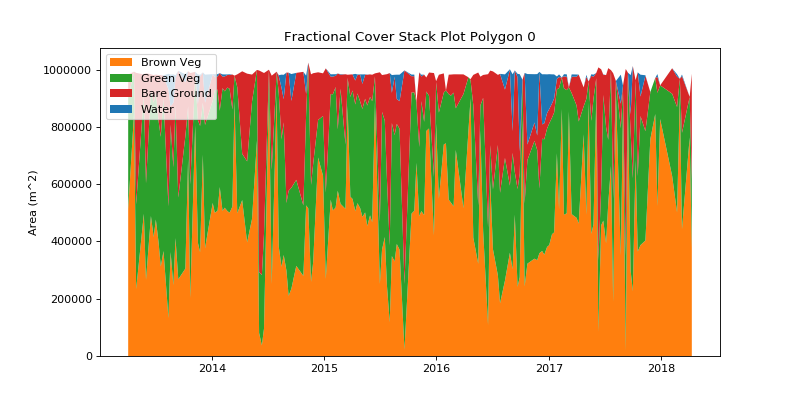

<IPython.core.display.Javascript object>


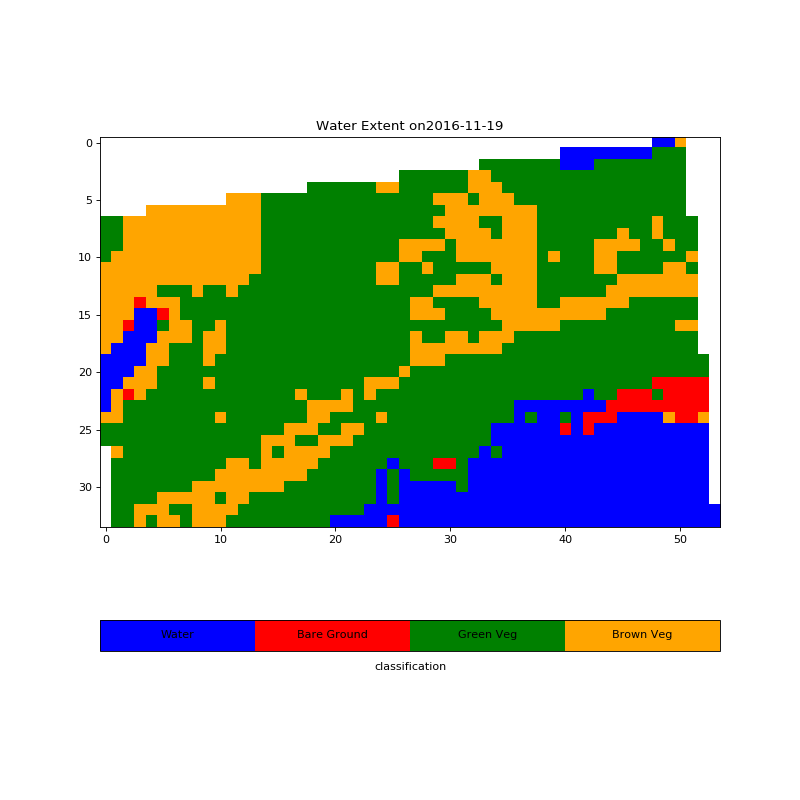

In [6]:
##Fractional Cover Stack Plot Extent App
%pylab notebook
import xarray
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
from matplotlib.colors import from_levels_and_colors

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
#from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities
import warnings
warnings.filterwarnings('ignore')


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None
    
if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def load_into_cube_fractional(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    global ds2
    dc = Datacube()


    ds1 = dc.load(product='ls8_fc_albers', 
                        group_by='solar_day', 
                        latitude=tuple(data['lat']), 
                        longitude=tuple(data['lon']),
                        time=tuple(data['time']), 
                        measurements = ['BS', 'PV', 'NPV'],
                        #output_crs='epsg:3577',
                        resolution = (-25,25))
    print ('loaded FC')
    
    ##To not overgrab wofs data lets use the minimum fractional cover date.
    dates = data['time']
    dates[0] = str(ds1.time.min().values)[:10]

    ds_water = dc.load(product='wofs_albers', 
                       group_by='solar_day',
                       latitude=tuple(data['lat']),
                       longitude=tuple(data['lon']),
                       time=tuple(dates), 
                       output_crs='epsg:3577',
                       resolution = (-25,25))

    # Filter Fractional Cover values below 20% RMSe
    #ds1 = ds2.where(ds2.UE.where(ds2.UE<=20.0))
    
    # Mask with WOFS
    wetwofl = masking.make_mask(ds_water, wet=True)
    wetwofl_time = wetwofl.where(ds_water.time == ds1.time)
    ds = ds1.where(ds1.time == ds_water.time)
    ds = ds.where(wetwofl.water==False)
    print ('loaded WOFL')

    return [ds, wetwofl_time]


global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})
graph = widgets.Output(layout={'border': '1px solid black'})


#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})



if 'loading' in locals():
    ds = None
    desc = ""
    print ('No Case Study Selected')
else:

    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'

    if 'loaded' in locals():
        if loaded['landsat8_frac'] != config['load_id'] or loaded['landsat8_frac'] is None:
            print ('Retrieving New Cube')
            ds, ds_water = load_into_cube_fractional()
            #ds1 = ds.where(ds.UE.where(ds.UE<=20.0))

            ds_area = (ds/100) * 625
            ds_water_area = ds_water * 625
            ds_all_raw = xarray.merge([ds_area,ds_water_area])
            ds_all = ds_all_raw.fillna(0)
            loaded['landsat8_frac'] = config['load_id']
   
    
    m3.add_layer(GeoJSON(data=geoJSON_Extent))

dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577

def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    time_slice = matplotlib.dates.num2date(timeOfInterest).date()
    time_slice = str(time_slice)
    time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
    label_html.value = '<b>Date selected from stack plot is ' + str(time_slice)[:10] + '</b>'

    
def test_ufunc(ds):
    STOP
    ds1 = xarray.Dataset()
    ds1.coords.update(ds.coords)
    ds1['maxidx'] = np.argmax([ds.BS, ds.PV,ds.NPV,ds.water])

    return ds1
    
def display_extent(active):
    
    time_slice = matplotlib.dates.num2date(timeOfInterest).date()
    time_slice = str(time_slice)
    time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')

    plot_graph = dataMasked.sel(time=[time_slice], method='nearest')
    
    shape_arr = plot_graph.water.values.shape
    
    a_b = np.zeros([shape_arr[1],shape_arr[2],4])
    a_b[...,0] = plot_graph.water.values
    a_b[...,1] = plot_graph.BS.values
    a_b[...,2] = plot_graph.PV.values
    a_b[...,3] = plot_graph.NPV.values
    
       
    #plot_me = xarray.Dataset()
    #plot_me.coords.update(plot_graph.isel(time=0).coords)
    #plot_me['class'] = np.argmax(a_b, axis = 2)
    plot_me = np.argmax(a_b, axis = 2)
    mask = np.isnan(plot_graph.water.values)[0]
    plot_me[mask] = -1
    plot_me = plot_me[firstrow:lastrow,firstcol:lastcol]
    cmap, norm = from_levels_and_colors([-0.5,0.5,1.5,2.5,3.5],['blue','red','green','orange'])
    
    if plt.fignum_exists(datasetID + 1):
        plt.figure(num= datasetID + 1, figsize=(10, 10))
        plt.cla()

        plt.imshow(plot_me,cmap=cmap, norm=norm)
    else:
        plt.figure(num= datasetID + 1, figsize=(10, 10))
        
        plt.imshow(plot_me,cmap=cmap, norm=norm)
        
        plt.title( 'Water Extent on' +  str(time_slice)[:10])

        cbar = plt.colorbar(orientation = 'horizontal')       

        cbar.ax.get_xaxis().set_ticks([])
        for j, lab in enumerate(['Water','Bare Ground','Green Veg','Brown Veg']):
            cbar.ax.text((2 * j + 1) / 8.0, 0.5, lab, ha='center', va='center')
        cbar.ax.get_xaxis().labelpad = 10
        cbar.ax.set_xlabel('classification')

def plot_FC(self, action, geo_json):
    global output_pandas
    global datasetID
    global ds
    global dataMasked
    global firstcol,firstrow,lastcol,lastrow


    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = ds_all.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        data_masked_mean_raw = drill_cube.isel(x=0,y=0)
        data_masked_mean = data_masked_mean_raw
        
        data_masked_mean_bare = data_masked_mean.BS
        data_masked_mean_green_veg = data_masked_mean.PV
        data_masked_mean_dead_veg = data_masked_mean.NPV
        data_masked_mean_water = data_masked_mean.water
        #global data_masked_mean_UE
        #data_masked_mean_UE = data_masked_mean.UE

        label = 'Point ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID


    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)
        geom_ogr = ogr.CreateGeometryFromJson(str(geom))

        geom_area = geom_ogr.GetArea()
        
        
        global mask
        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        
        total_area = mask.sum() * 625
        #print (total_area,geom_area)
        dataMasked = ds_all.where(mask)
                
        nan_mask = mask.astype('float')
        nan_mask[~mask] = np.nan
        
        nans = np.isnan(nan_mask)
        nancols = np.all(nans, axis=0) 
        nanrows = np.all(nans, axis=1) 
        
        firstcol = nancols.argmin() 
        firstrow = nanrows.argmin() 

        lastcol = len(nancols) - nancols[::-1].argmin() # 8, last index where not NAN
        lastrow = len(nanrows) - nanrows[::-1].argmin() # 10

        
        ###Confidence Mask not ready for use yet.
        #confidence_masked = ds.UE.where(mask)
        #confidence_masked_mean = confidence_masked.mean(dim = ['x','y'])
        
        data_masked_mean = dataMasked.sum(dim = ['x','y'])
        #data_masked_mean.all = data_masked_mean.sum(dim = 'time')

        data_masked_mean_filt = data_masked_mean.where(data_masked_mean<=total_area)
        data_masked_mean_bare = data_masked_mean_filt.BS
        data_masked_mean_green_veg = data_masked_mean_filt.PV
        data_masked_mean_dead_veg = data_masked_mean_filt.NPV
        data_masked_mean_water = data_masked_mean_filt.water
        

        
        label = 'Polygon ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID



    get_pandas = data_masked_mean.to_dataframe()
    get_pandas.rename(columns=lambda x: x + '_' + label, inplace=True)
    get_pandas = get_pandas[get_pandas.columns.drop(list(get_pandas.filter(regex='UE')))]

    output_pandas =  pd.concat([output_pandas,get_pandas],axis = 1)


    #color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c']
    fig = plt.figure(num=datasetID + 1, figsize=(10, 5))
    time_from = np.ravel(data_masked_mean.time)
    
    plt.ylabel('Area (m^2)')
    color_scheme = '#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'
    plt.stackplot(time_from,data_masked_mean_dead_veg, 
                 data_masked_mean_green_veg, 
                  data_masked_mean_bare, 
                  data_masked_mean_water,
                  colors = color_scheme,
                  labels=['Brown Veg','Green Veg','Bare Ground','Water'])
    plt.legend(loc='upper left')
    fig.canvas.mpl_connect('button_press_event', onclick)

    #Plotting confidence on the same graph
    #ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
    #color = 'tab:blue'
    #ax2.set_ylabel('confidence', color=color)  # we already handled the x-label with ax1
    #ax2.plot(time_from, confidence_masked_mean, color=color) 
    
    plt.title('Fractional Cover Stack Plot ' + label )
    plt.show()

    datasetID = datasetID + 1

    geoJSONs.append(geo_json)



    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_FC)
m3.add_control(draw_control3)

label_html = widgets.HTML(
        value="<b>Date selected from stack plot is </b>",
        layout=widgets.Layout(flex='1 1 auto', width='auto'))



button_plot =  widgets.Button(description='Plot Spatial Extent', 
               disabled=False,
               button_style='', # 'success', 'info', 'warning', 'danger' or ''
               tooltip='Click me', layout=widgets.Layout(flex='1 1 auto', width='auto'))

button_plot.on_click(display_extent)


plot_module = widgets.HBox([label_html, button_plot])



pixel_drill = widgets.VBox([m3,graph,out,plot_module])

pixel_drill


In [19]:
%macro fractional_cover_stack_plot_extentplot_app 17

Macro `fractional_cover_stack_plot_extentplot_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('store', 'geomedian_landsat5_band_indices_app')
 

In [20]:
%store fractional_cover_stack_plot_extentplot_app

Stored 'fractional_cover_stack_plot_extentplot_app' (Macro)


In [21]:
##Fractional Cover Stack Plot App
%pylab notebook
import xarray
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
from matplotlib.colors import from_levels_and_colors

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
#from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities
import warnings
warnings.filterwarnings('ignore')


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None
    
if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def load_into_cube_fractional(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    global ds2
    dc = Datacube()


    ds1 = dc.load(product='ls8_fc_albers', 
                        group_by='solar_day', 
                        latitude=tuple(data['lat']), 
                        longitude=tuple(data['lon']),
                        time=tuple(data['time']), 
                        measurements = ['BS', 'PV', 'NPV'],
                        #output_crs='epsg:3577',
                        resolution = (-25,25))
    print ('loaded FC')
    
    ##To not overgrab wofs data lets use the minimum fractional cover date.
    dates = data['time']
    dates[0] = str(ds1.time.min().values)[:10]

    ds_water = dc.load(product='wofs_albers', 
                       group_by='solar_day',
                       latitude=tuple(data['lat']),
                       longitude=tuple(data['lon']),
                       time=tuple(dates), 
                       output_crs='epsg:3577',
                       resolution = (-25,25))

    # Filter Fractional Cover values below 20% RMSe
    #ds1 = ds2.where(ds2.UE.where(ds2.UE<=20.0))
    
    # Mask with WOFS
    wetwofl = masking.make_mask(ds_water, wet=True)
    wetwofl_time = wetwofl.where(ds_water.time == ds1.time)
    ds = ds1.where(ds1.time == ds_water.time)
    ds = ds.where(wetwofl.water==False)
    print ('loaded WOFL')

    return [ds, wetwofl_time]


global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})
graph = widgets.Output(layout={'border': '1px solid black'})


#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})



if 'loading' in locals():
    ds = None
    desc = ""
    print ('No Case Study Selected')
else:

    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'

    if 'loaded' in locals():
        if loaded['landsat8_frac'] != config['load_id'] or loaded['landsat8_frac'] is None:
            print ('Retrieving New Cube')
            ds, ds_water = load_into_cube_fractional()
            #ds1 = ds.where(ds.UE.where(ds.UE<=20.0))

            ds_area = (ds/100) * 625
            ds_water_area = ds_water * 625
            ds_all_raw = xarray.merge([ds_area,ds_water_area])
            ds_all = ds_all_raw.fillna(0)
            loaded['landsat8_frac'] = config['load_id']
   
    
    m3.add_layer(GeoJSON(data=geoJSON_Extent))

dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577

def plot_FC(self, action, geo_json):
    global output_pandas
    global datasetID
    global ds
    global dataMasked
    global firstcol,firstrow,lastcol,lastrow


    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = ds_all.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        data_masked_mean_raw = drill_cube.isel(x=0,y=0)
        data_masked_mean = data_masked_mean_raw
        
        data_masked_mean_bare = data_masked_mean.BS
        data_masked_mean_green_veg = data_masked_mean.PV
        data_masked_mean_dead_veg = data_masked_mean.NPV
        data_masked_mean_water = data_masked_mean.water
        #global data_masked_mean_UE
        #data_masked_mean_UE = data_masked_mean.UE

        label = 'Point ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID


    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)
        geom_ogr = ogr.CreateGeometryFromJson(str(geom))

        geom_area = geom_ogr.GetArea()
        
        
        global mask
        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        
        total_area = mask.sum() * 625
        #print (total_area,geom_area)
        dataMasked = ds_all.where(mask)
                
        nan_mask = mask.astype('float')
        nan_mask[~mask] = np.nan
        
        nans = np.isnan(nan_mask)
        nancols = np.all(nans, axis=0) 
        nanrows = np.all(nans, axis=1) 
        
        firstcol = nancols.argmin() 
        firstrow = nanrows.argmin() 

        lastcol = len(nancols) - nancols[::-1].argmin() # 8, last index where not NAN
        lastrow = len(nanrows) - nanrows[::-1].argmin() # 10

        
        ###Confidence Mask not ready for use yet.
        #confidence_masked = ds.UE.where(mask)
        #confidence_masked_mean = confidence_masked.mean(dim = ['x','y'])
        
        data_masked_mean = dataMasked.sum(dim = ['x','y'])
        #data_masked_mean.all = data_masked_mean.sum(dim = 'time')

        data_masked_mean_filt = data_masked_mean.where(data_masked_mean<=total_area)
        data_masked_mean_bare = data_masked_mean_filt.BS
        data_masked_mean_green_veg = data_masked_mean_filt.PV
        data_masked_mean_dead_veg = data_masked_mean_filt.NPV
        data_masked_mean_water = data_masked_mean_filt.water
        

        
        label = 'Polygon ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID



    get_pandas = data_masked_mean.to_dataframe()
    get_pandas.rename(columns=lambda x: x + '_' + label, inplace=True)
    get_pandas = get_pandas[get_pandas.columns.drop(list(get_pandas.filter(regex='UE')))]

    output_pandas =  pd.concat([output_pandas,get_pandas],axis = 1)


    #color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c']
    fig = plt.figure(num=datasetID + 1, figsize=(10, 5))
    time_from = np.ravel(data_masked_mean.time)
    
    plt.ylabel('Area (m^2)')
    color_scheme = '#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'
    plt.stackplot(time_from,data_masked_mean_dead_veg, 
                 data_masked_mean_green_veg, 
                  data_masked_mean_bare, 
                  data_masked_mean_water,
                  colors = color_scheme,
                  labels=['Brown Veg','Green Veg','Bare Ground','Water'])
    plt.legend(loc='upper left')
    fig.canvas.mpl_connect('button_press_event', onclick)

    #Plotting confidence on the same graph
    #ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
    #color = 'tab:blue'
    #ax2.set_ylabel('confidence', color=color)  # we already handled the x-label with ax1
    #ax2.plot(time_from, confidence_masked_mean, color=color) 
    
    plt.title('Fractional Cover Stack Plot ' + label )
    plt.show()

    datasetID = datasetID + 1

    geoJSONs.append(geo_json)



    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_FC)
m3.add_control(draw_control3)



button_plot =  widgets.Button(description='Plot Spatial Extent', 
               disabled=False,
               button_style='', # 'success', 'info', 'warning', 'danger' or ''
               tooltip='Click me', layout=widgets.Layout(flex='1 1 auto', width='auto'))

button_plot.on_click(display_extent)

pixel_drill = widgets.VBox([m3,graph,out])

pixel_drill


Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [22]:
%macro fractional_cover_stack_plot_app 20

Macro `fractional_cover_stack_plot_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('store', 'fractional_cover_stack_plot_extentplot_app')
 

In [23]:
%store fractional_cover_stack_plot_app

Stored 'fractional_cover_stack_plot_app' (Macro)


In [24]:
#%%time
##Fractional Cover Line Plot App
%pylab notebook
import xarray
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities
import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


global first_plot
first_plot = True


if 'loaded' not in locals():
    loaded = {}
    loaded['sent'] = None
    loaded['landsat8_geomed'] = None
    loaded['landsat7_geomed'] = None
    loaded['landsat5_geomed'] = None
    loaded['landsat8_frac'] = None
    loaded['landsat7_frac'] = None
    loaded['landsat5how_frac'] = None

def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def load_into_cube_fractional(measurements = None, cloud_mask = False):

    data = load_config(case_study)

    global ds2
    dc = Datacube()

    ds1 = dc.load(product='ls8_fc_albers', 
                        group_by='solar_day', 
                        latitude=tuple(data['lat']), 
                        longitude=tuple(data['lon']),
                        time=tuple(data['time']), 
                        measurements = ['BS', 'PV', 'NPV'],
                        #output_crs='epsg:3577',
                        resolution = (-25,25))
    print ('loaded FC')
    
    ##To not overgrab wofs data lets use the minimum fractional cover date.
    dates = data['time']
    dates[0] = str(ds1.time.min().values)[:10]

    ds_water = dc.load(product='wofs_albers', 
                       group_by='solar_day',
                       latitude=tuple(data['lat']),
                       longitude=tuple(data['lon']),
                       time=tuple(dates), 
                       output_crs='epsg:3577',
                       resolution = (-25,25))
    
    # Filter Fractional Cover values below 20% RMSe
    
    #ds1 = ds2.where(ds2.UE.where(ds2.UE<=20.0))
    
    # Mask with WOFS
    wetwofl = masking.make_mask(ds_water, wet=True)
    wetwofl_time = wetwofl.where(ds_water.time == ds1.time)
    ds = ds1.where(ds1.time == ds_water.time)
    ds = ds.where(wetwofl.water==False)
    print ('loaded WOFL')

    return [ds, wetwofl_time]

global first_plot
first_plot = True


global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})
graph = widgets.Output(layout={'border': '1px solid black'})


#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})



if 'loading' in locals():
    ds = None
    desc = ""
    print ('No Case Study Selected')
else:

    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'

    if 'loaded' in locals():
        if loaded['landsat8_frac'] != config['load_id'] or loaded['landsat8_frac'] is None:
            print ('Retrieving New Cube')
            ds, ds_water = load_into_cube_fractional()
            #ds1 = ds.where(ds.UE.where(ds.UE<=20.0))

            ds_area = (ds/100) * 625
            ds_water_area = ds_water * 625
            ds_all_raw = xarray.merge([ds_area,ds_water_area])
            ds_all = ds_all_raw.fillna(0)
            loaded['landsat8_frac'] = config['load_id']

    m3.add_layer(GeoJSON(data=geoJSON_Extent))

dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
EPSG = 3577

labels = []

def plot_FC(self, action, geo_json):
    global output_pandas
    global datasetID
    global ds
    global first_plot

    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = ds_all.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        data_masked_mean_raw = drill_cube.isel(x=0,y=0)
        data_masked_mean = data_masked_mean_raw.resample(time='1M').median()

        
        data_masked_mean_bare = data_masked_mean.BS/625 * 100
        data_masked_mean_green_veg = data_masked_mean.PV/625 * 100
        data_masked_mean_dead_veg = data_masked_mean.NPV/625 * 100
        data_masked_mean_water = data_masked_mean.water/625 * 100
        #global data_masked_mean_UE
        #data_masked_mean_UE = data_masked_mean.UE

        label = 'Point ' + str(datasetID)
        
        labels.append(label)
        geo_json['properties']['datasetID'] = datasetID


    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)
        geom_ogr = ogr.CreateGeometryFromJson(str(geom))

        geom_area = geom_ogr.GetArea()
        
        
        global mask
        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        
        total_area = mask.sum() * 625
        print (total_area,geom_area)
        dataMasked = ds_all.where(mask)
        ###Confidence Mask not ready for use yet.
        #confidence_masked = ds.UE.where(mask)
        #confidence_masked_mean = confidence_masked.mean(dim = ['x','y'])
        
        data_masked_mean1 = dataMasked.sum(dim = ['x','y'])
        
        data_masked_mean = data_masked_mean1.resample(time='1M').median()
        #data_masked_mean.all = data_masked_mean.sum(dim = 'time')

        data_masked_mean_filt = data_masked_mean.where(data_masked_mean<=total_area)
        data_masked_mean_bare = data_masked_mean_filt.BS / total_area * 100
        data_masked_mean_green_veg = data_masked_mean_filt.PV /total_area * 100
        data_masked_mean_dead_veg = data_masked_mean_filt.NPV /total_area * 100
        data_masked_mean_water = data_masked_mean_filt.water / total_area * 100
        

        
        label = 'Polygon ' + str(datasetID)
        labels.append(label)
        geo_json['properties']['datasetID'] = datasetID



    get_pandas = data_masked_mean.to_dataframe()
    get_pandas.rename(columns=lambda x: x + '_' + label, inplace=True)
    get_pandas = get_pandas[get_pandas.columns.drop(list(get_pandas.filter(regex='UE')))]

    output_pandas =  pd.concat([output_pandas,get_pandas],axis = 1)

    time_from = np.ravel(data_masked_mean.time)

    if first_plot == True:
        global f,axarr
        
        f, axarr = plt.subplots(4, sharey = True,figsize=(10, 15))
        #f.suptitle('Fractional Cover Landsat 8')
        
        axarr[0].set_title( 'Bare Earth')
        axarr[1].set_title( 'Green Veg')
        axarr[2].set_title( 'Brown Veg')
        axarr[3].set_title( 'Water')
        
        first_plot = False

    
    axarr[0].plot(time_from, data_masked_mean_bare.interpolate_na(dim = 'time', method = 'nearest'), marker ='*')
    axarr[1].plot(time_from, data_masked_mean_green_veg.interpolate_na(dim = 'time', method = 'nearest'), marker ='*')
    axarr[2].plot(time_from, data_masked_mean_dead_veg.interpolate_na(dim = 'time', method = 'nearest'), marker ='*')
    axarr[3].plot(time_from, data_masked_mean_water.interpolate_na(dim = 'time', method = 'nearest'), marker ='*')
    plt.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

    
    datasetID = datasetID + 1

    geoJSONs.append(geo_json)



    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_FC)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([m3,graph,out])

pixel_drill


Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [25]:
%macro fractional_cover_line_plot_app 24

Macro `fractional_cover_line_plot_app` created. To execute, type its name (without quotes).
=== Macro contents: ===
#%%time
##Fractional Cover Line Plot App
get_ipython().run_line_magic('pylab', 'notebook')
import xarray
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities
import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


global first_plot
first_plot = True


if 'loaded' not in locals():
    loaded = {}
    loaded[

In [26]:
%store fractional_cover_line_plot_app

Stored 'fractional_cover_line_plot_app' (Macro)
